In [48]:
import pandas as pd
import numpy as np
import networkx as nx
from pyvis import network as net
from pyvis.network import Network
import random
#from serpapi import GoogleScholarSearch
import json
import requests

# Creation of DataFarme

In [114]:
#import given dataframe nodes
nodes = pd.read_csv("Data/nodes.csv")

nodes['author_id'] = None
nodes['cited_by'] = None 
nodes['interests'] = None
nodes.to_csv('Data/nodes.csv', index=False)

edges = pd.DataFrame(columns=['author1','author2']) 
edges.to_csv('Data/edges.csv', index=False)

## ES 1
A partire da nodes.csv, utilizzare la libreria Python SerpAPI per scaricare, per ciascuno dei 7 autori elencati:
- author_id: ID identificativo del profilo Google Scholar
- cited_by: numero totale di citazioni ricevute
- interests: elenco degli interessi di ciascun autore
Sfruttando la libreria Python Pandas, usare la struttura dati DataFrame per aggiornare il file originale con apposite colonne e memorizzarlo nella cartella /data.
## 2. Analisi dei Coautori tramite SerpAPI su Google Scholar

### a. Ottenere i Coautori dei 7 Autori Principali

Per ciascuno dei 7 autori, utilizzare il suo ID per accedere al relativo profilo Google Scholar e scaricare l'elenco dei suoi coautori utilizzando SerpAPI. Con tale elenco di nomi:;

#### a.1. Ricerca dei Coautori su Google Scholar

Utilizzare le SerpAPI per cercare su Google Scholar un ricercatore che corrisponde a ciascun nome nella lista di coautori. Per ogni risultato, salvare le informazioni come `name`, `affiliations`, `author_id`, `cited_by`, e `interests` in un nuovo DataFrame contenente tutte queste informazioni relative ai coautori dei 7 autori originari.

### b. Concatenazione dei DataFrame

Concatenare il DataFrame contenente le informazioni sui 7 autori principali con quello dei coautori generato al punto 2a in un unico DataFrame.

### c. Creazione del DataFrame delle Relazioni di Co-Authorship

Creare un terzo DataFrame con le colonne `author1` e `author2` che rappresenta le co-authorship. In questo DataFrame, una riga rappresenta un arco di coauthorship tra due autori. La co-authorship è binaria, non pesata.

#### Esempio

Se David La Barbera e Michael Soprano sono coautori, una riga del DataFrame creato al punto 2c rappresenterà questa relazione.

### Risultati Finali

A questo punto, saranno stati prodotti due DataFrame:

- Uno contenente le informazioni relative agli autori (originali + i relativi coautori), con le colonne `name`, `affiliations`, `cited_by`, `interests`. Salvare come `nodes.csv` nella cartella `/data` tale DataFrame.

- Un altro per le relazioni di co-authorship dai 7 autori principali verso i relativi coautori, con colonne `author1` e `author2`. Salvare come `edges.csv` nella cartella `/data` tale DataFrame.

In [115]:
#key in use right now
apikey = "9e35e5273396934a1f34354188e7b0509d31c9c99833802e8128d156b17a8b1d"

In [116]:
#overwrite the row of nodes with df_update in the right position
#if the author given isn't in nodes, then it will get concatenated

def update_nodes(df_update, nodes):
    
    nodesMod = pd.read_csv(r'Data/nodes.csv') #read nodes.csv updated
    
    print('nome: ', df_update["name"][0])

    #check if the author is in nodes using attribute name as parameter
    if (nodesMod["name"] == df_update["name"][0]).any():
        print('già presente in nodes')

        #if author is already in nodes update the present row with df_update (may not be completed)
        for index in range(len(nodes)):
            #sroll down all the names in nodes and compare it with the df_update one
            if nodes["name"][index] == df_update["name"][0]:
                print('sta sovrascrivendo con: ', df_update.iloc[0])

                nodesMod.iloc[index]=df_update.iloc[0] #replace the row of nodesMod with df_update
                nodesMod.to_csv(r'Data/nodes.csv', index=False) #overwrite the csv with the one having the new row
    else:
        #if the author isn't already in nodes, concatenates it
        nodesMod = pd.concat([nodesMod, df_update], ignore_index=True)
        nodesMod.to_csv(r'Data/nodes.csv', index=False) #overwrite the csv by adding df_update at the end
            

In [117]:
# author_profile update nodes.csv with name, affiliations, author_id, cited_by, interests of a given author
# this function requires the name and affiliation of the author to search for and nodes (it contains only the original authors)

def author_profile(apiKey, name, affiliation, nodes):

    base_url = "https://serpapi.com/search"

    #search among scholar profiles for the one with the given name
    params = {
        "api_key": apiKey,
        "engine": "google_scholar_profiles",
        "hl": "en",
        "mauthors": name
    }

    #save the request response in json
    response = requests.get(base_url, params=params)
    results = response.json()
    
    #save the results in a json
    name_json = "json/" + name + ".json"
    with open(name_json, 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=4)
    
    notFound = True #used to see if among the profiles found there is one with the same name and affiliation as those given
    indexProfile = 0 #if correct profile is found, indexProfile change with the corresponding index, otherwise take profile 0
    
    #scroll through profiles to verifies if the profile found is the one that we are searching for and save the corrisponding index
    for index, profile in enumerate(results["profiles"]):
        if (affiliation in profile["affiliations"]) and (name in profile["name"]):
            indexProfile = index #change the original index
            notFound = False #we have found the searched profile
            break #the desired profile has been found -> no need to continue
    
    interests = ' '  #set interest as "empty"
    
    prifileDesired = results["profiles"][indexProfile] #json with all the information of the profile
    
    authorId = prifileDesired["author_id"] 
    citedBy = prifileDesired["cited_by"]
        
    #not all profiles have the key 'interests' in the dict (coauthors)
    if 'interests' in prifileDesired:
        if prifileDesired["interests"] != '': #if key interest exist but it is empty 
            interests = ", ".join([i['title'] for i in prifileDesired["interests"]])  # select only titles for each interest, join to remove the square brackets (now seen as a single string instead of a list)
    else:
        #create a new key in the dict and set it as a empty string
        prifileDesired["interests"] = ' '
    
    #if we found the profile:
    if not notFound: 
        #create a new row of the dataframe with all the information needed and return it
        df_update = pd.DataFrame({'name': [name],'affiliations': [affiliation],'author_id': [authorId],'cited_by': [citedBy],'interests': [interests]})
        
        #adds the author to nodes if it is not already present
        update_nodes(df_update, nodes)
    
    #if there is no profile with the correct name and affiliation, we've taken the first one (we've already taken the necessary data)
    else:
        #create a new row of the dataframe with all the information needed and return it (affiliation is a string empty)
        df_update = pd.DataFrame({'name': [name],'affiliations': " ",'author_id': [authorId],'cited_by': [citedBy],'interests': [interests]})
        
        #adds the author to nodes if it is not already present
        update_nodes(df_update, nodes)

In [118]:
############
#TEST (da eliminare)
############

#print(author_profile(apikey,"Lei Han" ,"The University of Queensland", nodes))

In [119]:
##################
#ELIMINARE????
##################

'''
def nodes_information(apikey, df):
    
    #iterate the row of the given df, for each one makes the call to the author_profile
    for index, row in df.iterrows():
        author_data = author_profile(apikey, row['name'], row['affiliations'])
 '''       

"\ndef nodes_information(apikey, df):\n    \n    #iterate the row of the given df, for each one makes the call to the author_profile\n    for index, row in df.iterrows():\n        author_data = author_profile(apikey, row['name'], row['affiliations'])\n "

## Main es 1

In [120]:
##################
#ELIMINARE????
##################

'''
#get the final dataframe of the 7 originals authors with name, affiliations, author_id, cited_by, interests 
nodes_information(apikey, nodes)
'''

'\n#get the final dataframe of the 7 originals authors with name, affiliations, author_id, cited_by, interests \nnodes_information(apikey, nodes)\n'

In [121]:
#get_profile_coauthors find all coauthors of the given author and save them in nodes and edges
#for every author check that the dict's key needed exist and if they are empty

def get_profile_coauthors(apiKey, authorID, nodes):
    
    base_url = "https://serpapi.com/search"

    #search among scholar profiles for the one with the given author_id
    params = {
        "api_key": apiKey,
        "engine": "google_scholar_author",
        "hl": "en",
        "author_id": authorID
    }
    
    #save the request response in json
    response = requests.get(base_url, params = params)
    results = response.json()
    
    #save the results in a json
    name_json = "json/"+authorID + ".json"
    with open(name_json, 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=4)
    
    edges = pd.read_csv(r'Data/edges.csv')  #read edges.csv
    
    authorName = results["author"] #saves the name of the author given as input with the Id
    
    for coauthor in results['co_authors']:  #for each coauthor
        
        #create a couples author-coauthor in both ways (used to check if it is already present in edges.csv)
        edgesCopules = [(authorName["name"], coauthor['name']), (coauthor['name'], authorName["name"])]
        
        notFound = True #the couple isn't already present
        
        #cycles through edges.csv and check if the pair to insert, edgesCopules, is already present (in both directions)
        for index, row in edges.iterrows():
            if (row['author1'], row['author2']) in edgesCopules or (row['author2'], row['author1']) in edgesCopules:
                #there is already a link between author and coauthor or vice versa
                notFound = False #the couple is present
        
        #if the pair is not present it is concatenated to edegs.csv
        if(notFound):
            row_edge = pd.DataFrame([{'author1' : authorName["name"], 'author2': coauthor['name']}])
            edges = pd.concat([edges, row_edge], ignore_index=True)

        #add a coauthor to nodes:
        #check if 'affiliations' is a key on the coauthor dict:
        if 'affiliations' in coauthor:
            if coauthor['affiliations'] == '': #check if affiliation is empty
                author_profile(apiKey, coauthor['name'], '', nodes) #calls author_profile with the name of the co-author and empty affiliation
            else:
                author_profile(apiKey, coauthor['name'], coauthor['affiliations'], nodes)#calls author_profile with the name and affiliation
                
        #if the coauthor's dict hasn't 'affiliations' key create it and calls author_profile
        else:
            coauthor['affiliations'] = " "
            author_profile(apiKey, coauthor['name'], coauthor['affiliations'], nodes)
    
    #when all coauthors of the main author have been insert in nodes and concatenated into edges (if not already present), overwrites edges 
    edges.to_csv(r'Data/edges.csv', index=False)

In [133]:
#nodes = pd.read_csv("Data/nodes.csv")

get_profile_coauthors(apikey,'egHDpFkAAAAJ',nodes)


nome:  Stefano Mizzaro
già presente in nodes
sta sovrascrivendo con:  name                                              Stefano Mizzaro
affiliations    Full professor of Computer Science and Informa...
author_id                                            2wvJC6IAAAAJ
cited_by                                                     4744
interests       Information retrieval, mobile systems, scholar...
Name: 0, dtype: object
nome:  Kevin Roitero
già presente in nodes
sta sovrascrivendo con:  name                                                Kevin Roitero
affiliations                                  University of Udine
author_id                                            1xd52jMAAAAJ
cited_by                                                      692
interests       Artificial Intelligence, Crowdsourcing and Hum...
Name: 0, dtype: object
nome:  Gianluca Demartini
già presente in nodes
sta sovrascrivendo con:  name                                           Gianluca Demartini
affiliations    A

In [132]:
nodes

,name,affiliations,author_id,cited_by,interests
0,David La Barbera,Università Degli Studi Di Udine,NaN,NaN,NaN
1,Michael Soprano,Postdoctoral Research Fellow at the University...,NaN,NaN,NaN
2,Kevin Roitero,University of Udine,NaN,NaN,NaN
3,Stefano Mizzaro,Full professor of Computer Science and Informa...,NaN,NaN,NaN
4,Damiano Spina,"School of Computing Technologies, RMIT University",NaN,NaN,NaN
5,Gianluca Demartini,Associate Professor at the University of Queen...,NaN,NaN,NaN
6,Eddy Maddalena,"Università degli Studi di Udine, Italy",NaN,NaN,NaN


## Main es 2

In [58]:
'''

#read nodes.csv (!!should only contain the names and affiliations of the 7 original authors)
nodes = pd.read_csv(r'Data/nodes.csv') 

#cycle the authors and takes their coauthors (and their required information), adds them to nodes and to edges with the relevant arch
for author in nodes["author_id"]:
    get_profile_coauthors(apikey, author, nodes)
'''

'\n\n#read nodes.csv (!!should only contain the names and affiliations of the 7 original authors)\nnodes = pd.read_csv(r\'Data/nodes.csv\') \n\n#cycle the authors and takes their coauthors (and their required information), adds them to nodes and to edges with the relevant arch\nfor author in nodes["author_id"]:\n    get_profile_coauthors(apikey, author, nodes)\n'

In [90]:
nodes

,name,affiliations,author_id,cited_by,interests
0,David La Barbera,Università Degli Studi Di Udine,NaN,NaN,NaN
1,Michael Soprano,Postdoctoral Research Fellow at the University...,NaN,NaN,NaN
2,Kevin Roitero,University of Udine,NaN,NaN,NaN
3,Stefano Mizzaro,Full professor of Computer Science and Informa...,NaN,NaN,NaN
4,Damiano Spina,"School of Computing Technologies, RMIT University",NaN,NaN,NaN
5,Gianluca Demartini,Associate Professor at the University of Queen...,NaN,NaN,NaN
6,Eddy Maddalena,"Università degli Studi di Udine, Italy",NaN,NaN,NaN




# Parte 3
Usare il due dataset per creare grafico indiretto:
a. Generare un grafo indiretto che ne rappresenta le informazioni contenute.
Salvare (serializzare) il grafo in locale nella cartella /graphs .
b. Visualizzare il grafo prodotto colorando i nodi a seconda del loro grado con le
seguenti colorazioni: grigio per nodi con grado uguale a 1, blu per nodi con grado compreso tra 2 e 10, viola per nodi con grado compreso tra 11 e 20, giallo per nodi con grado maggiore di 20. Inoltre, per ciascun nodo visualizzare il nome dell’autore. Salvare la visualizzazione nella cartella /visualizations.




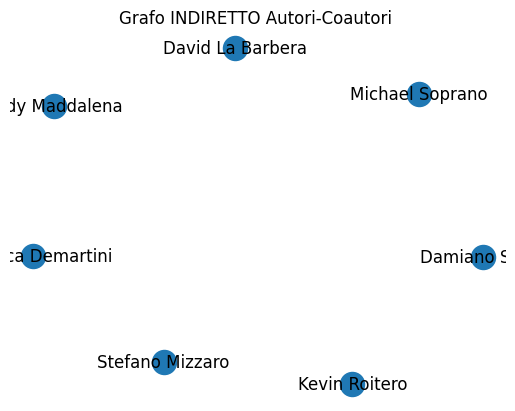

In [59]:
import matplotlib.pyplot as plt

# Creazione di un grafo vuoto
G = nx.Graph()
# Leggi i CSV
nodi = pd.read_csv('Data/nodes.csv')
edges = pd.read_csv('Data/edges.csv')

# Aggiungi i nodi al grafo
nodes = nodi['name'].tolist()
G.add_nodes_from(nodes)


# Aggiungi gli archi al grafo
edges = edges[['author1', 'author2']].values.tolist()
G.add_edges_from(edges)

# Aggiungi un titolo al grafo
plt.title("Grafo INDIRETTO Autori-Coautori ")

nx.draw(G, with_labels=True)


{'David La Barbera': 0, 'Michael Soprano': 0, 'Kevin Roitero': 0, 'Stefano Mizzaro': 0, 'Damiano Spina': 0, 'Gianluca Demartini': 0, 'Eddy Maddalena': 0}


TypeError: float() argument must be a string or a real number, not 'dict_values'

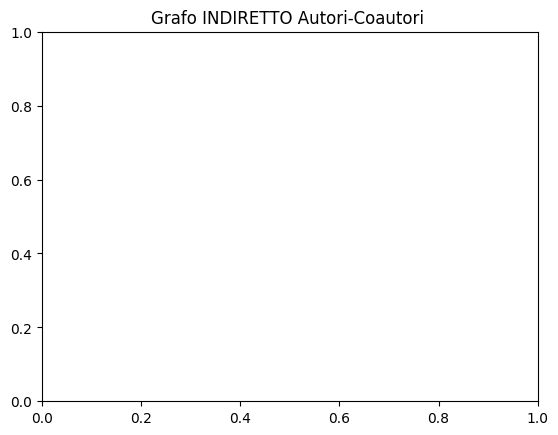

In [60]:
import matplotlib.pyplot as plt
import networkx as nx
# Creazione di un grafo vuoto
G = nx.Graph()
# Leggi i CSV
nodi = pd.read_csv('Data/nodes.csv')
edges = pd.read_csv('Data/edges.csv')


# Aggiungi i nodi al grafo
nodes = nodi['name'].tolist()
G.add_nodes_from(nodes)

# Aggiungi gli archi al grafo
edges = edges[['author1', 'author2']].values.tolist()
G.add_edges_from(edges)

'''
grigio per nodi con grado uguale a 1, blu per nodi con grado compreso tra 2 e 10, viola per nodi con grado compreso tra 11 e 20, giallo per nodi con grado maggiore di 20
'''
#calcolo dela deegree
degrees = dict(G.degree())
print(degrees)
colori_specifici={}
for nodo, grado in degrees.items():
    if grado == 1:
        colori_specifici[nodo] = 'gray'
        #colore grigio
    elif grado in range(2, 10):
        colori_specifici[nodo] = 'blue'
        #colore blu
    elif grado in range(11, 20):
        colori_specifici[nodo] = 'purple'
    elif grado:
        colori_specifici[nodo] = 'yellow'
        #colore gioallo

# Aggiungi un titolo al grafo
plt.title("Grafo INDIRETTO Autori-Coautori ")
# 1.3 | Visualizzo il grafo
nx.draw(G, with_labels=True, node_color = colori_specifici.values())

In [ ]:
#ES 2
def draw(G, pos, measures, title):
    nodes = nx.draw_networkx_nodes(G, pos, node_size = 150, cmap = plt.cm.plasma,
                                   node_color  = list(measures.values()),
                                   nodelist = measures.keys()
                                   )
    edges = nx.draw_networkx_edges(G, pos)
    plt.title(title)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()
    # 2.1 | Genero grafo con proprietà piccolo mondo
G = nx.watts_strogatz_graph(15, 4, .3)

# 2.2 | Centralità di grado per tutti i nodi
degrees = dict(G.degree())
df = pd.DataFrame(list(degrees.items()), columns=['node', 'degree'])
print("Centralità di grado:")
display(df)


# 2.3 | Calcolo le altre priprietà richieste
num_edges = G.number_of_edges()
# Grado medio 
avg_degree = sum(degrees.values()) / G.number_of_nodes()
# Densità del grafo
density = nx.density(G)
# Nodo più connesso
max_degree_node = max(degrees, key=degrees.get)

print(f"Number of edges: {num_edges}")
print(f"Average degree: {avg_degree:.2f}")
print(f"Density: {density:.2f}")
print(f"Most connected node: {max_degree_node}")
# 2.4 | Visualizzo usando lo spring layout
draw(
    G,
    nx.spring_layout(G),
    nx.degree_centrality(G),
    title = "Visualizzazione della rete Piccolo Mondo generata"
      )

In [ ]:




#usare la stessa funzione iniziale, quando passi l'id del autore e restituisce tutti i dati, di cui recuprei i coautori, crei direttamente il datframe quello dei nodi, ciclano n-volte( che saranno il numero di coaurori, e crei una riga insrendo l'Id del autore + vicino il coautore.